In [26]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm


C:\Users\chees\AppData\Local\Temp\ipykernel_17232\1887431989.py:13: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x[i] = np.random.rand(1)
C:\Users\chees\AppData\Local\Temp\ipykernel_17232\1887431989.py:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y[i] = w[1]*x[i] + b[1] + np.random.randn(1)*np.sqrt(v[1])
C:\Users\chees\AppData\Local\Temp\ipykernel_17232\1887431989.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y[i] = w[0]*x[i] + b[0] + np.random.randn(1

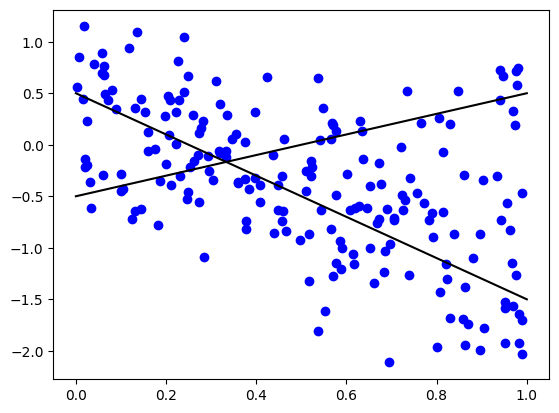

In [27]:
#Generating the data given the code in the assignment

np.random.seed(0)
n = 200 #sample size
K = 2 #number of lines
e = np.array([0.7,0.3]) #mixing weights
w = np.array([-2,1]) #slopes of lines
b = np.array([0.5,-0.5]) #offsets of lines
v = np.array([0.2,0.1]) #variances
x = np.zeros([n])
y = np.zeros([n])
for i in range(0,n):
    x[i] = np.random.rand(1)
    if np.random.rand(1) < e[0]:
        y[i] = w[0]*x[i] + b[0] + np.random.randn(1)*np.sqrt(v[0])
    else:
        y[i] = w[1]*x[i] + b[1] + np.random.randn(1)*np.sqrt(v[1])
plt.plot(x,y,'bo')
t = np.linspace(0, 1, num=100)
plt.plot(t,w[0]*t+b[0],'k')
plt.plot(t,w[1]*t+b[1],'k')
plt.show()



In [28]:


def e_step(x, y, params):
    epsilons, weights, biases, variances = params
    num_samples = len(x)
    num_components = len(weights)
    
    respons = np.zeros((num_samples, num_components))
    
    for i in range(num_samples):
        for k in range(num_components):
            respons[i, k] = epsilons[k] * norm.pdf(y[i], loc=weights[k]*x[i] + biases[k], scale=np.sqrt(variances[k]))
    
    respons /= np.sum(respons, axis=1, keepdims=True)
    
    return respons

def m_step(x, y, respons):
    num_components = respons.shape[1]
    
    epsilons = np.mean(respons, axis=0)
    
    weights = np.zeros(num_components)
    biases = np.zeros(num_components)
    variances = np.zeros(num_components)
    
    for k in range(num_components):
        weights[k] = np.sum(respons[:, k] * y * x) / np.sum(respons[:, k] * x**2)
        biases[k] = np.sum(respons[:, k] * (y - weights[k]*x))
        variances[k] = np.sum(respons[:, k] * (y - weights[k]*x - biases[k])**2) / np.sum(respons[:, k])
    
    return epsilons, weights, biases, variances

# Initialization
epsilons = np.array([0.5, 0.5])  # initial mixing weights
weights = np.array([-1, 1])       # initial slopes
biases = np.array([0, 0])         # initial biases
variances = np.array([0.2,0.1])      # initial variances

# EM Algorithm
max_iterations = 100
tolerance = 1e-6
for iteration in range(max_iterations):
    respons = e_step(x, y, (epsilons, weights, biases, variances))
    new_epsilons, new_weights, new_biases, new_variances = m_step(x, y, respons)
    
    # Check for convergence
    if np.all(np.abs(new_epsilons - epsilons) < tolerance) and \
       np.all(np.abs(new_weights - weights) < tolerance) and \
       np.all(np.abs(new_biases - biases) < tolerance) and \
       np.all(np.abs(new_variances - variances) < tolerance):
        break
    
    epsilons, weights, biases, variances = new_epsilons, new_weights, new_biases, new_variances

print("Converged after {} iterations".format(iteration+1))
print("Mixing weights:", epsilons)
print("Weights:", weights)
print("Biases:", biases)
print("Variances:", variances)


Converged after 15 iterations
Mixing weights: [0.50000001 0.49999999]
Weights: [-0.85142776 -0.85142773]
Biases: [6.91956104 6.91956084]
Variances: [47.33250877 47.33250599]


In [29]:

import numpy as np
from scipy.stats import norm

def e_step(x, y, params):
    epsilons, weights, biases, variances = params
    num_samples = len(x)
    num_components = len(weights)
    
    respons = np.zeros((num_samples, num_components))
    
    for i in range(num_samples):
        for k in range(num_components):
            respons[i, k] = epsilons[k] * norm.pdf(y[i], loc=weights[k]*x[i] + biases[k], scale=np.sqrt(variances[k]))
    
    respons /= np.sum(respons, axis=1, keepdims=True)
    
    return respons

def m_step(x, y, respons):
    num_components = respons.shape[1]
    
    epsilons = np.mean(respons, axis=0)
    
    weights = np.zeros(num_components)
    biases = np.zeros(num_components)
    variances = np.zeros(num_components)
    
    for k in range(num_components):
        weights[k] = np.sum(respons[:, k] * y * x) / np.sum(respons[:, k] * x**2)
        biases[k] = np.sum(respons[:, k] * (y - weights[k]*x))
        variances[k] = np.sum(respons[:, k] * (y - weights[k]*x - biases[k])**2) / np.sum(respons[:, k])
    
    return epsilons, weights, biases, variances

# Initialization
epsilons = np.array([0.5, 0.5])  # initial mixing weights
weights = np.array([-1, 1])       # initial slopes
biases = np.array([0.1, 0])         # initial biases
variances = np.array([0.2, 0.1])  # initial variances

# EM Algorithm
max_iterations = 100
tolerance = 1e-6
for iteration in range(max_iterations):
    respons = e_step(x, y, (epsilons, weights, biases, variances))
    new_epsilons, new_weights, new_biases, new_variances = m_step(x, y, respons)
    
    # Check for convergence
    if np.all(np.abs(new_epsilons - epsilons) < tolerance) and \
       np.all(np.abs(new_weights - weights) < tolerance) and \
       np.all(np.abs(new_biases - biases) < tolerance) and \
       np.all(np.abs(new_variances - variances) < tolerance):
        break
    
    epsilons, weights, biases, variances = new_epsilons, new_weights, new_biases, new_variances

print("Converged after {} iterations".format(iteration+1))
print("Mixing weights:", epsilons)
print("Slopes:", weights)
print("Biases:", biases)
print("Variances:", variances)


Converged after 17 iterations
Mixing weights: [0.5 0.5]
Slopes: [-0.85142775 -0.85142774]
Biases: [6.91956094 6.91956094]
Variances: [47.33250738 47.33250737]
